# RoboGarden ML Capstone Project - Credit Card Fraud Detection (Part B Rev1)

## Reduced Set of Features and Undersampling.  RFC and MLP are run on a reduced set of 10 features based on feature importance run in Part A.  RFC and MLP are run on an undersampled set and evaluated on the full test set and then the full test set results are calibrated using the method described by Dal Pozzolo et al.  The third set of ROC / PRC charts is the relevant calibrated result.

### Eight classifiers were tested in Part A.  Dataset analysis and visualization is included in Part A.  Dataset preparation will be duplicated but not explained.

## *This Project is the course completion submission for the RoboGarden Professional DataScience & Machine Learning Bootcamp.   July 2019*     (Oct 2019 update)  

## *Objective:  Detect fraudulent credit card transactions based on transaction history.*

### *This is an update of the project with data visualization and classifier optimization on all data features except for time.  This update addresses splitting the data to be consistent between the full train / test sets and the undersampled train / test sets so that no samples from the full test set are in the undersampled train set.

### Autoencoders is in Part C.*

## Information:
Description: The dataset consists 284,807 credit card transactions made by European cardholders in September 2013

* Link: https://data.world/raghu543/credit-card-fraud-data

* File: creditcard.csv

* Features: 
    * Time (integer): transaction time (seconds since first transaction)  
    * V1 – V28 (decimal): results of PCA transformation  
    * Amount (decimal): transaction amount  
    * Class (T/F): fraudulent/genuine transaction (target)
* Notes:
    * Feature V1-V28 are the principal components obtained with PCA
    * The original features and background information about the data are not provided due to confidentiality issues
* License: Public domain (CC0)

In [1]:
#Import General Libraries
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import livelossplot
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
# Load Data
dataset = pd.read_csv('creditcard.csv')

In [3]:
dataset.head()

,time,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v21,v22,v23,v24,v25,v26,v27,v28,amount,class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,False
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,False
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,False
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,False
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,False


In [4]:
dataset['class'].value_counts()

False    284315
True        492
Name: class, dtype: int64

In [5]:
# Drop Duplicates
df = dataset.drop_duplicates()
df['class'].value_counts()

False    283253
True        473
Name: class, dtype: int64

In [6]:
# ReIndex df so that there are no missing index values
df.index=range(df.shape[0])

## *Start with the complete set, drop the 'time' feature and split into train & test subsets and preserve the ratio of fraudulent samples in both using "stratify" in train_test_split.*  

In [7]:
y = df['class']
y.shape

(283726,)

In [8]:
dfx = df.drop(['time','class'], axis = 1)
dfx.shape

(283726, 29)

In [9]:
x_train, x_test, y_train, y_test = train_test_split(dfx,y, stratify = y, test_size = 0.25, random_state = 6)

In [10]:
y_train.value_counts()

False    212439
True        355
Name: class, dtype: int64

In [11]:
y_test.value_counts()

False    70814
True       118
Name: class, dtype: int64

### Retain number of positives & negatives from train & test sets for use in calculating classification counts for changing decision thresholds.

In [12]:
N, P = y_test.value_counts()
Ntr, Ptr = y_train.value_counts()
N, P, Ntr, Ptr

(70814, 118, 212439, 355)

In [13]:
Test_Set = x_test  # Reserve a copy of x_test that is not scaled so that the actual amounts can be referenced

In [14]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

### The test and train sets are complete and cover the entire population and are balanced with an equal proportion of fraud samples in each set.
#  

## Prepare functions for plots and reports

In [15]:
def Prob_Hist(model_name,probs):
    plt.figure(figsize=(12,4)) 
    sns.distplot(probs[:,1], bins = 100, color = 'tab:red', label = 'Sample Probability ', kde = False)
    plt.title((('Histogram of Prediction Probability for {}').format(model_name)), weight = 'bold', fontsize = 16)
    plt.xlabel('Classifier Probability', fontsize = 14)
    plt.ylabel( 'Log No. of Samples')
    plt.yscale('log')
    plt.legend()
    plt.show()

In [16]:
def ROC_Plot(model_name, y_test, y_pred, probs, P, N):

    fpr_, tpr_, thresholds_ = roc_curve(y_test, probs[:,1])
    roc_auc = auc(fpr_, tpr_)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    
    plt.title((('{}\nReceiver Operating Characteristic').format(model_name)), weight = 'bold', fontsize = 16)
    plt.plot(fpr_, tpr_, 'purple', lw = '3', label='ROCAUC = %0.2f'% roc_auc)
    plt.scatter(fpr[1], tpr[1],s = 100, c = 'r', label = ('Conf. Matrix {:0.1e}, {:0.2f}').format(fpr[1], tpr[1]))
    plt.plot([0,1],[0,1],'r--')
    
    plt.legend(loc='lower right', fontsize = 14)
    plt.xlim([-0.01,1.01])
    plt.ylim([-0.0,1.01])
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.ylabel('True Positive Rate', weight = 'bold', fontsize = 14)
    plt.xlabel('False Positive Rate', weight = 'bold', fontsize = 14)
    plt.grid('black')

    return fpr_, tpr_, thresholds_

In [17]:
def PRC_Plot(model_name, y_test, y_pred, probs, P, N):

    precision_, recall_, _ = precision_recall_curve(y_test, probs[:,1])
    AP = average_precision_score(y_test, probs[:,1])
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    single_pt_recall = tpr[1]
    single_pt_precision = (tpr[1]*P)/(tpr[1]*P + fpr[1]*N)
    
    plt.title((('{}\nPrecision - Recall Curve').format(model_name)), weight = 'bold', fontsize = 16)
    plt.step(recall_, precision_, 'blue', lw = '3', where = 'pre', label='au_prc = %0.2f'% AP)
    plt.scatter(single_pt_recall, single_pt_precision, s = 100, c = 'r', label = ('Conf. Matrix: {:0.2f}, {:0.2f}').format(single_pt_recall, single_pt_precision))
      
    plt.legend(loc='lower left', fontsize = 14)
    plt.xlim([-0.01,1.01])
    plt.ylim([-0.0,1.01])
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.ylabel('Precision', weight = 'bold', fontsize = 14)
    plt.xlabel('Recall', weight = 'bold', fontsize = 14)
    plt.grid('black')

    return

In [18]:
def Det_Amt_PLot(model_name, Test_set, y_test, y_pred):
    # Calculate the amount of fraud detected, missed, and false positive
    fraud_amount_IDd = Test_set

    fraud_amount_IDd['TP'] = 0
    fraud_amount_IDd['FP'] = 0
    fraud_amount_IDd['FN'] = 0
    
    fraud_amount_IDd['pred'] = y_pred
    fraud_amount_IDd['ytest'] = y_test
    
    fraud_amount_IDd['TP'] = fraud_amount_IDd['pred'] * fraud_amount_IDd['ytest']
    fraud_amount_IDd['FP'] = fraud_amount_IDd['pred'] * (fraud_amount_IDd['ytest'] == 0)
    fraud_amount_IDd['FN'] = (fraud_amount_IDd['pred'] == 0) * fraud_amount_IDd['ytest']

    fraud_amount_IDd['fraudIDd'] = fraud_amount_IDd['amount'] * fraud_amount_IDd['TP']
    fraud_amount_IDd['False_+ve'] = fraud_amount_IDd['amount'] *fraud_amount_IDd['FP']
    fraud_amount_IDd['fraud_notIDd'] = fraud_amount_IDd['amount'] * fraud_amount_IDd['FN']
    
    # PLot histogram of fraud detected, missed, and false positives
    plt.figure(figsize=(12,4))
    sns.distplot(fraud_amount_IDd['fraudIDd'][fraud_amount_IDd['TP'] == 1], bins = 40, color = 'tab:blue', label = 'Fraud Identified', kde = False) 
    sns.distplot(fraud_amount_IDd['fraud_notIDd'][fraud_amount_IDd['FN'] == 1], bins = 40, color = 'tab:orange', label = 'False -ve', kde = False)
    sns.distplot(fraud_amount_IDd['False_+ve'][fraud_amount_IDd['FP'] == 1], bins = 40, color = 'tab:red', label = 'False +ve', kde = False)
    
    plt.title((('Histogram of FP, TP, & FN Amounts for {}').format(model_name)), weight = 'bold', fontsize = 16)
    plt.xlabel('Amount', fontsize = 14)
    plt.yscale('log')
    plt.legend()
    plt.show()
    
    # Print Sums
    fraudIDd = fraud_amount_IDd['fraudIDd'].sum()
    fraud_notIDd = fraud_amount_IDd['fraud_notIDd'].sum()
    false_pos_total = fraud_amount_IDd['False_+ve'].sum()
    print(('Fraud total identified is {:.{prec}f},\nFraud total missed is {:.{prec}f},\nNormal total misclassified is {:.{prec}f}').format(fraudIDd,fraud_notIDd, false_pos_total, prec = 2))

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV
from time import time

from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc, classification_report
from sklearn.metrics import precision_recall_curve, average_precision_score, precision_score, f1_score
from inspect import signature

In [20]:
def Conf_Matrix(_title, cm):
    sns.set(font_scale=1.4)
    plt.title(('{}\n Confusion Matrix').format(_title))
    c_map = ['blue',  'orange']
    sns.heatmap(cm, cmap = c_map,  annot=True, fmt = 'g', annot_kws={"size": 24, "weight": 'bold'})
    plt.xlabel('Normal                  Fraud\nPredicted')
    plt.ylabel('Actual\n Fraud            Normal')
    
    return

In [21]:
# PLot for True Positive Counts vs. Decision Threshold
def FP_TP_Count_vs_Threshold(model_name, fpr_, tpr_, thresholds_, P, N, ylim, DT):
    plt.step(thresholds_, tpr_*P, c='blue', lw = '3', where = 'mid', label = 'True +ve')
    plt.step(thresholds_, fpr_*N, c='orange', lw = '3', where = 'mid', label = 'False +ve')
    plt.plot([DT,DT],[0,ylim], 'r--')
    plt.ylim(-0.01, ylim)
    plt.xlim(-0.01, 1.01)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.title(('{}\n FP & TP Count vs. Decision Threshold').format(model_name), weight = 'bold', fontsize = 16)
    plt.ylabel('FP Count, TP Count', weight = 'bold', fontsize=14)
    plt.xlabel('Classifier Decision Threshold', weight = 'bold', fontsize=14)
    plt.legend(loc='lower left', fontsize = 14)
    plt.grid('black')
    return


In [22]:
# Single Call for combined ROC & Precision-Recall Curve, plus False Positive / True Positive Counts vs. Decision Threshold
def ROC_Pre_Count_Plots(title, y_test, y_pred, probs, cm, P, N, DT):
        
    plt.figure(figsize=(12,6))
    gs0 = gridspec.GridSpec(1, 2)    
    ax1 = plt.subplot(gs0[0])    
    fpr_, tpr_, thresholds_ = ROC_Plot(title, y_test, y_pred, probs, P, N)

    ax2 = plt.subplot(gs0[1])     
    PRC_Plot(title, y_test, y_pred, probs, P, N)
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(12,6))
    gs1 = gridspec.GridSpec(1, 2)   
    ax3 = plt.subplot(gs1[0])
    Conf_Matrix(title, cm)

    ax4 = plt.subplot(gs1[1])
    FP_TP_Count_vs_Threshold(title, fpr_, tpr_, thresholds_, P, N, P+7, DT)
    plt.tight_layout()
    plt.show()

In [23]:
# Function to get reports from optimizations
def GetResults(title, clf, x_test, y_test, P, N, flag, DT): 
    if flag == 1:
        print(clf.best_estimator_.get_params())
    elif flag == 0:   
        print('model parameters: ',clf.get_params())
    else:
        print(' ')
    
    y_pred, probs = clf.predict(x_test),  clf.predict_proba(x_test)
    cm, AU_PRC = confusion_matrix(y_test, y_pred),  average_precision_score(y_test, probs[:,1])
    F1 = f1_score(y_test, y_pred)
    
    print(('\n{} gives AU_PRC of {:.3f}and F1 Score of {:.3f}\n').format(title, AU_PRC, F1))
    
    ROC_Pre_Count_Plots(title, y_test, y_pred, probs, cm, P, N, DT)

    return y_pred, probs, F1

In [24]:
def FP_TP_Count_Table(model_name, fpr_, tpr_, thresholds_, P, N, range_):
    print('{:^65}'.format('ROC Curve TP & FP Count by Classifier Decision Threshold:'))
    print(('{:^65}\n').format(model_name))
    print('-'*65)
    print(('{:>5}{:>12}{:>12}{:>12}{:>12}{:>12}').format('i', 'Threshold', 'TPR  ', 'TP Count', 'FPR   ', 'FP Count'))
    print('-'*65)
    for i in range(range_):        
        print(('{:>5}{:{width}.{prec}f}{:{width}.{prec}f}{:{width}.{prec2}f}{:{width}.{prec2}e}{:{width}.{prec2}f}').format(i, thresholds_[i], tpr_[i], tpr_[i]*P, fpr_[i], fpr_[i]*N, width =12, prec = 3, prec2 =1)) 

# *Fewer Features*

## Reduce the number of features to 10 (v14, v17, v10, v12, v16, v11, v4, v3, v7, v9) and check performance on Random Forest & MLP.

In [25]:
# Drop features keeping top 10 from feature importance result
dfx_10 = dfx.drop(['v1', 'v2', 'v5', 'v6', 'v8', 'v13', 'v15', 'v18', 'v19', 'v20',
       'v21', 'v22', 'v23', 'v24', 'v25', 'v26', 'v27', 'v28'], axis = 1)
dfx_10.head()

,v3,v4,v7,v9,v10,v11,v12,v14,v16,v17,amount
0,2.536347,1.378155,0.239599,0.363787,0.090794,-0.551600,-0.617801,-0.311169,-0.470401,0.207971,149.62
1,0.166480,0.448154,-0.078803,-0.255425,-0.166974,1.612727,1.065235,-0.143772,0.463917,-0.114805,2.69
2,1.773209,0.379780,0.791461,-1.514654,0.207643,0.624501,0.066084,-0.165946,-2.890083,1.109969,378.66
3,1.792993,-0.863291,0.237609,-1.387024,-0.054952,-0.226487,0.178228,-0.287924,-1.059647,-0.684093,123.50
4,1.548718,0.403034,0.592941,0.817739,0.753074,-0.822843,0.538196,-1.119670,-0.451449,-0.237033,69.99


In [26]:
x_train_10, x_test_10, y_train_10, y_test_10 = train_test_split(dfx_10, y, stratify = y, test_size = 0.25, random_state = 6)

In [27]:
#  Save a copy of train & test sets with amount before scaling to measure performance against amount identified
Test_Set_10 = x_test_10
Train_set_10 = x_train_10
x_train_10 =  x_train_10.iloc[:,0:10]
x_test_10 = x_test_10.iloc[:,0:10]
x_test_10[0:5][:]

,v3,v4,v7,v9,v10,v11,v12,v14,v16,v17
261092,1.083907,1.156584,-1.384707,2.577532,-0.398150,-1.030632,0.873628,-1.169164,-0.375988,0.462084
101269,0.585759,0.017661,-0.077298,-0.895438,-0.563033,0.840236,0.266429,1.311771,0.428500,-0.130119
129533,-1.130026,0.471868,1.152082,-0.271176,-0.195106,0.956858,0.084526,1.066976,0.350714,-0.434841
79561,-0.283318,3.033874,1.200761,0.136435,-0.207380,-0.988903,-0.537333,0.176618,1.101212,-0.371017
233338,-0.218416,1.370863,-0.311308,0.856663,0.159186,-0.891397,0.411452,0.033599,0.337449,-0.640693


In [28]:
x_train_10 =  scaler.fit_transform(x_train_10)
x_test_10 = scaler.transform(x_test_10)

In [29]:
Ns, Ps = y_test_10.value_counts()
Ns, Ps

(70814, 118)

In [30]:
Ntrs, Ptrs = y_train_10.value_counts()
Ntrs, Ptrs

(212439, 355)

In [31]:
# Fit RF model with 10 features using same optimized parameters as in Part A
RFC_model_10 = RandomForestClassifier(n_estimators = 150, max_depth = 50, criterion = 'entropy', random_state = 6, n_jobs = -1).fit(x_train_10, y_train_10)

 

Random Forest - 10 Features gives AU_PRC of 0.838and F1 Score of 0.849



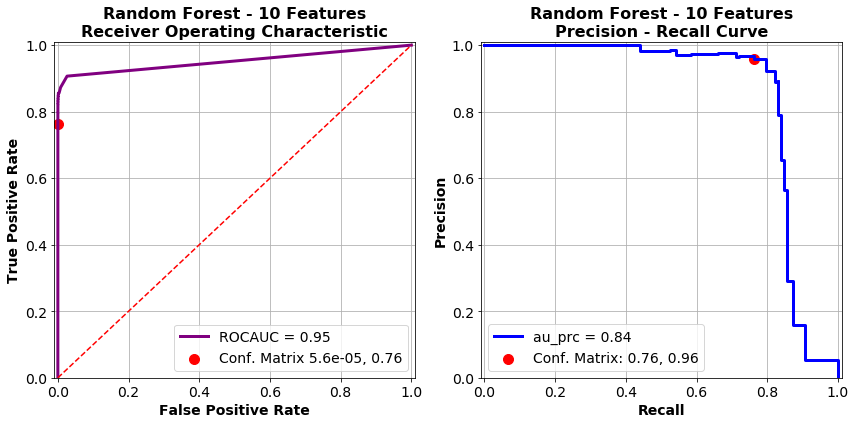

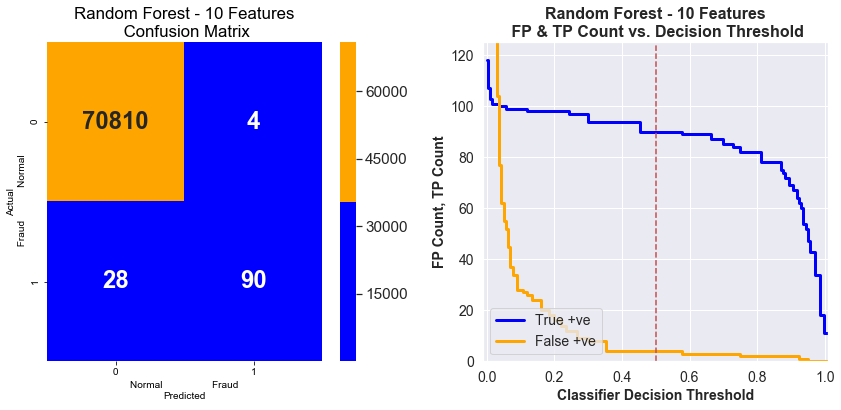

In [32]:
y_pred, probs, F1_Score = GetResults('Random Forest - 10 Features', RFC_model_10, x_test_10, y_test_10, Ps, Ns, 2, 0.5)

## Run RandomSearch on the reduced feature set and see if the performance improves.

In [33]:
params={'n_estimators':[120, 135, 150, 165, 180], 'max_depth':[30, 50, 70, 80],'criterion':['gini', 'entropy']}

model = RandomForestClassifier(random_state = 6)
clf = RandomizedSearchCV(model, param_distributions=params, n_iter=12, cv=3, scoring = 'f1', verbose=1, n_jobs = -1)

clf.fit(x_train_10, y_train_10)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed: 30.3min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [34]:
clf.best_params_

{'n_estimators': 150, 'max_depth': 80, 'criterion': 'entropy'}

model parameters:  {'bootstrap': True, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 80, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 150, 'n_jobs': None, 'oob_score': False, 'random_state': 6, 'verbose': 0, 'warm_start': False}

Random Forest - 10 Features gives AU_PRC of 0.838and F1 Score of 0.849



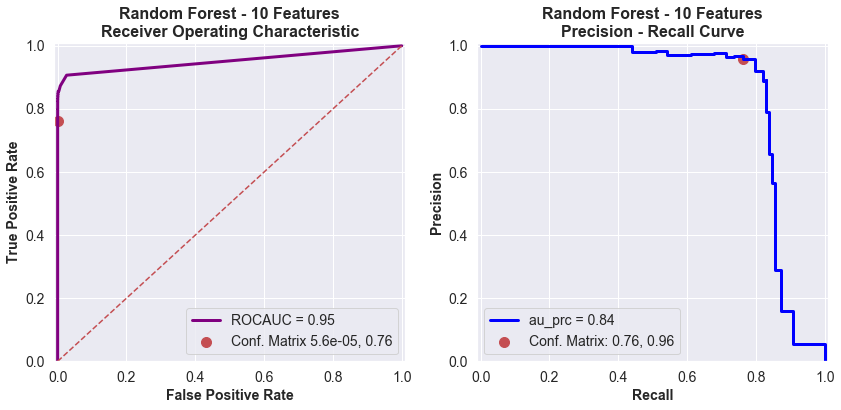

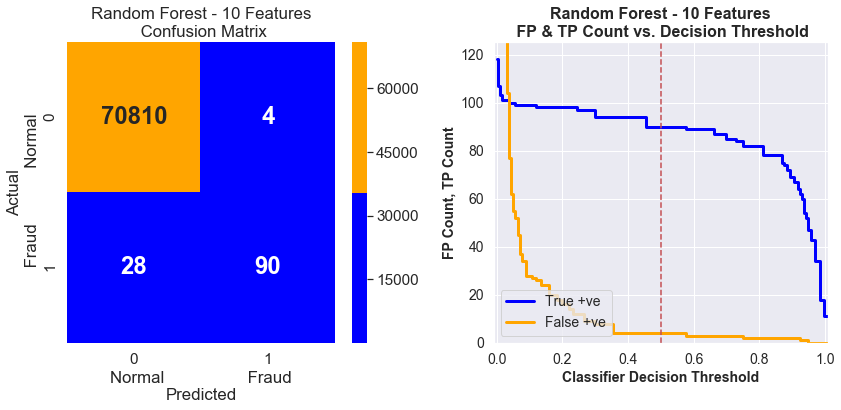

In [35]:
RFC_10_Opt_model = clf.best_estimator_
y_pred, probs, F1_Score = GetResults('Random Forest - 10 Features', RFC_10_Opt_model, x_test_10, y_test_10, Ps, Ns, 0, 0.5)

In [36]:
fpr_, tpr_, thresholds_ = roc_curve(y_test, probs[:,1])
FP_TP_Count_Table('Random Forest - 10 Features', fpr_, tpr_, thresholds_, Ps, Ns, 25)

    ROC Curve TP & FP Count by Classifier Decision Threshold:    
                   Random Forest - 10 Features                   

-----------------------------------------------------------------
    i   Threshold       TPR      TP Count      FPR       FP Count
-----------------------------------------------------------------
    0       2.000       0.000         0.0     0.0e+00         0.0
    1       1.000       0.093        11.0     0.0e+00         0.0
    2       0.993       0.153        18.0     0.0e+00         0.0
    3       0.980       0.288        34.0     0.0e+00         0.0
    4       0.960       0.364        43.0     0.0e+00         0.0
    5       0.953       0.398        47.0     0.0e+00         0.0
    6       0.947       0.441        52.0     1.4e-05         1.0
    7       0.940       0.458        54.0     1.4e-05         1.0
    8       0.933       0.508        60.0     1.4e-05         1.0
    9       0.927       0.525        62.0     1.4e-05         1.0
   10    

#### A change in the decision threshold to 0.39 from the default of 0.5 would increase the TP's to 94 while maintaining the FP's at 4 and improve the recall to 0.797 and improve the precision by a marginal amount.

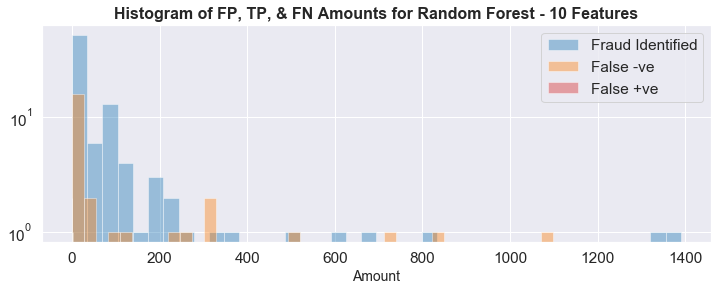

Fraud total identified is 9667.49,
Fraud total missed is 4659.40,
Normal total misclassified is 4.28


In [38]:
Det_Amt_PLot('Random Forest - 10 Features', Test_Set_10, y_test_10, y_pred)

### Performance is essentially the same as with all features. 

### First: Re-Optimize the MLP as the features are significantly different.  Drop the poorest performing activation & solvers from the prior run in Part A

In [39]:
params={'hidden_layer_sizes':[70,80,90,100,110], 'activation':['tanh','relu'],'solver':['lbfgs','sgd','adam']}

model =  MLPClassifier(batch_size = 1000, max_iter = 200,random_state = 6)
clf = RandomizedSearchCV(model, param_distributions=params, n_iter=15, cv=3, verbose=2, scoring = 'f1', return_train_score=True, n_jobs = -1)

clf.fit(x_train_10, y_train_10)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  3.1min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                           batch_size=1000, beta_1=0.9,
                                           beta_2=0.999, early_stopping=False,
                                           epsilon=1e-08,
                                           hidden_layer_sizes=(100,),
                                           learning_rate='constant',
                                           learning_rate_init=0.001,
                                           max_iter=200, momentum=0.9,
                                           n_iter_no_change=10,
                                           nesterovs_momentum=True, power_t=0.5,
                                           random...6, shuffle=True,
                                           solver='adam', tol=0.0001,
                                           validation_fraction=0.1,
                          

In [40]:
clf.best_params_

{'solver': 'adam', 'hidden_layer_sizes': 90, 'activation': 'tanh'}

model parameters:  {'activation': 'tanh', 'alpha': 0.0001, 'batch_size': 1000, 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': 90, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_iter': 200, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': 6, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}

MLP - 10 Features gives AU_PRC of 0.824and F1 Score of 0.830



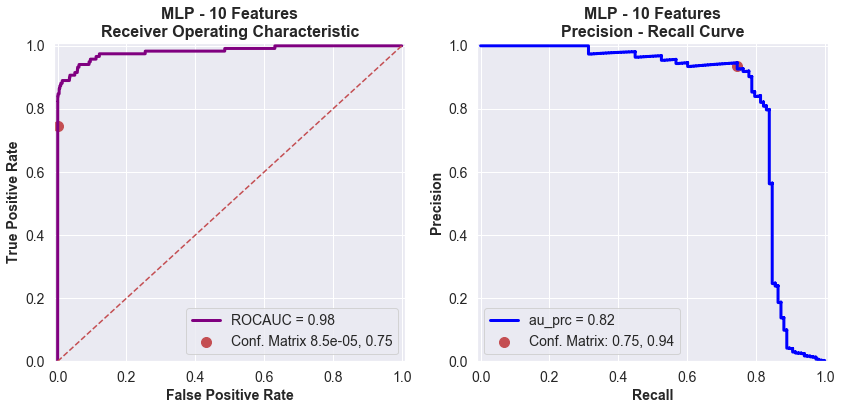

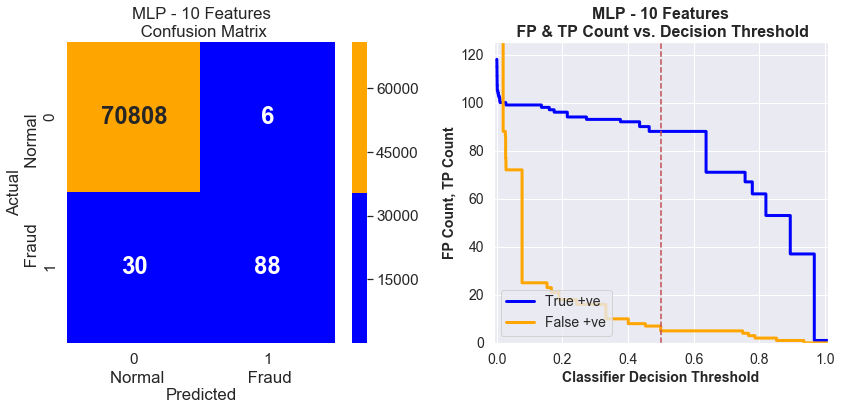

In [41]:
MLP_10_Opt_model = clf.best_estimator_
y_pred, probs, F1_Score = GetResults('MLP - 10 Features', MLP_10_Opt_model, x_test_10, y_test_10, Ps, Ns, 0, 0.5)

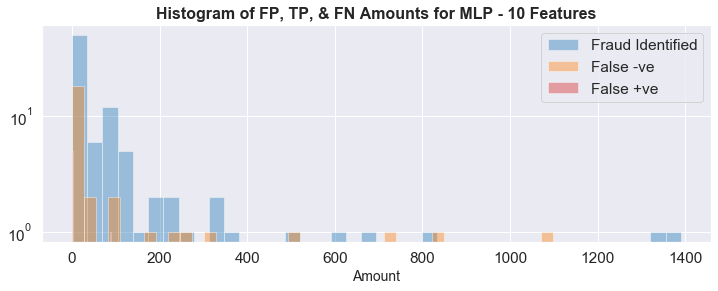

Fraud total identified is 9816.55,
Fraud total missed is 4510.34,
Normal total misclassified is 95.04


In [42]:
Det_Amt_PLot('MLP - 10 Features', Test_Set_10, y_test_10, y_pred)

### For MPL, AU_PRC & fraud amount detected dropped slightly vs. using all features. 

### Performance dropped slightly for both classifiers vs. using all features.

# *Under Sampling*

### Drop the majority of the normal samples and create a more balanced dataset.  Target 10% of normal transactions. 

### Prepare an undersampled train & test set starting with df prepared after dropping duplicates. Split into train & test sets using the same random state, then sample out 90% of normal transactions in each.  Then shuffle and re-index.


In [43]:
y = df['class']
y.shape

(283726,)

In [44]:
# Keep class in the dfx in order to sample out non-fraud based on class.  
# Remove Class from the X sets after undersampled sets are complete before training 
dfx = df.drop(['time'], axis = 1)
dfx.shape

(283726, 30)

In [45]:
x_train, x_test, y_train, y_test = train_test_split(dfx, y, stratify = y, test_size = 0.25, random_state = 6)

In [46]:
y_train.value_counts()

False    212439
True        355
Name: class, dtype: int64

In [47]:
y_test.value_counts()

False    70814
True       118
Name: class, dtype: int64

In [48]:
train_F = x_train['amount'][y_train == 1].sum()
train_N = x_train['amount'][y_train == 0].sum()
print(('Train set fraud & normal totals are {:,.2f} and {:,.2f}').format(train_F, train_N))

Train set fraud & normal totals are 44,264.50 and 18,684,082.27


In [49]:
test_F = x_test['amount'][y_test == 1].sum()
test_N = x_test['amount'][y_test == 0].sum()
print(('Test set fraud & normal totals are {:,.2f} and {:,.2f}').format(test_F, test_N))

Test set fraud & normal totals are 14,326.89 and 6,359,328.02


### Retain number of positives (frauds) & negatives (legitimate transactions) from train & test sets for use in calculating classification counts for changing decision thresholds.

In [50]:
N, P = y_test.value_counts()
Ntr, Ptr = y_train.value_counts()
N, P, Ntr, Ptr

(70814, 118, 212439, 355)

In [51]:
Test_Set = x_test  # Reserve a copy of x_test that is not scaled so that the actual amounts can be referenced

### Now make an undersampled set from x-train & x_test before dropping the class values from them.

In [52]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((212794, 30), (212794,), (70932, 30), (70932,))

In [53]:
df_x_train = pd.DataFrame(x_train)
df_x_train.head()

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,...,v21,v22,v23,v24,v25,v26,v27,v28,amount,class
237819,-1.039755,-0.314374,0.982691,1.204603,0.395747,0.207391,-0.655719,-0.981174,0.657194,0.848749,...,1.020142,1.209459,0.199233,-0.267434,-1.084523,0.044775,-0.239252,0.421453,4.99,False
281046,1.355525,-0.111476,-1.792941,3.835940,1.338924,0.909873,0.997619,-0.059012,-1.534525,1.244422,...,0.364688,0.718965,-0.161240,-0.992639,0.128856,0.240470,-0.067607,-0.033368,259.80,False
159074,-1.304773,0.976467,1.076500,-0.604122,0.287821,-0.118099,0.101977,0.443382,0.360659,-1.188923,...,0.062825,0.315343,-0.524802,0.537664,0.597628,0.701715,-0.145012,-0.180930,7.00,False
193444,0.033422,0.898134,0.302947,-0.597541,0.489160,-1.024356,1.043811,-0.216994,-0.139323,-0.438573,...,-0.246792,-0.497576,0.072200,-0.003485,-0.482998,0.141317,0.253890,0.098277,4.49,False
32984,-0.679181,0.691394,1.091387,-0.336704,0.827947,0.863240,0.583566,-0.940804,-2.216885,0.808178,...,0.075894,-1.567825,-0.177831,-1.226306,0.298543,-0.464554,0.010381,-0.179030,45.00,False


In [54]:
# Get an undersample dataset
from sklearn.utils import shuffle

normal_train = df_x_train[df_x_train['class'] == 0].sample(n = int(28324*0.75))
fraud_train = df_x_train[df_x_train['class'] == 1]
train_under = pd.merge(normal_train, fraud_train, how = 'outer')
train_under = shuffle(train_under)
train_under.index = range(train_under.shape[0])
train_under['class'].value_counts()

False    21243
True       355
Name: class, dtype: int64

In [55]:
df_x_test = pd.DataFrame(x_test)
df_x_test.head()

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,...,v21,v22,v23,v24,v25,v26,v27,v28,amount,class
261092,1.555758,-1.452335,1.083907,1.156584,-2.305628,-0.057251,-1.384707,0.265286,2.577532,-0.398150,...,0.209233,0.836054,0.168395,1.021334,-0.577322,0.668563,0.014198,-0.003573,150.00,False
101269,-1.088008,1.406897,0.585759,0.017661,-0.680907,-0.913926,-0.077298,0.832801,-0.895438,-0.563033,...,0.278178,0.406564,-0.011389,0.533912,-0.436732,0.250169,-0.294748,0.014174,1.50,False
129533,-0.028713,-2.137497,-1.130026,0.471868,-0.769471,-0.685681,1.152082,-0.334428,-0.271176,-0.195106,...,0.384514,-0.530583,-0.729831,0.098425,0.268050,1.003824,-0.256442,0.094684,696.00,False
79561,-1.612187,-4.620148,-0.283318,3.033874,-2.444004,0.413464,1.200761,-0.204880,0.136435,-0.207380,...,0.925431,-0.564915,-1.269103,0.445767,-0.369228,0.891521,-0.312783,0.268275,1446.27,False
233338,1.926625,-0.101082,-0.218416,1.370863,-0.534975,-0.594620,-0.311308,-0.074628,0.856663,0.159186,...,-0.207480,-0.508746,0.377999,-0.033906,-0.391780,-0.984794,0.050783,-0.022562,19.95,False


In [56]:
normal_test = df_x_test[df_x_test['class'] == 0].sample(n = int(28324*0.25))
fraud_test = df_x_test[df_x_test['class'] == 1]
test_under = pd.merge(normal_test, fraud_test, how = 'outer')
test_under = shuffle(test_under)
test_under.index = range(test_under.shape[0])
test_under['class'].value_counts()

False    7081
True      118
Name: class, dtype: int64

#### Now drop the class column from the full sample x-train and x_test arrays.  The split train_under and test_under into x & y arrays.

In [57]:
x_train = x_train.iloc[:,:29]
x_test = x_test.iloc[:,:29]
x_train.shape, x_test.shape

((212794, 29), (70932, 29))

In [58]:
x_train_u = train_under.iloc[:,:29]
y_train_u = train_under['class']
x_test_u = test_under.iloc[:,:29]
y_test_u = test_under['class']
x_train_u.shape, y_train_u.shape, x_test_u.shape, y_test_u.shape

((21598, 29), (21598,), (7199, 29), (7199,))

In [59]:
#Replace True / False with 1 & 0 in y undersampled sets
y_train_u = y_train_u.apply(lambda x: 0 if x == False else 1)
y_test_u = y_test_u.apply(lambda x: 0 if x == False else 1)
y_train[0:5], y_test[0:5]

(237819    False
 281046    False
 159074    False
 193444    False
 32984     False
 Name: class, dtype: bool, 261092    False
 101269    False
 129533    False
 79561     False
 233338    False
 Name: class, dtype: bool)

In [60]:
# Reserve x_test amounts before scaling and get fraud & normal totals in x_test

#Verify the undersampled sets have the same fraud totals as the full sets
Test_Set_U = x_test_u
x_u_test_fraud_total = x_test_u['amount'][y_test_u == 1].sum()
x_u_test_normal_total =x_test_u['amount'][y_test_u == 0].sum()
x_u_train_fraud_total = x_train_u['amount'][y_train_u == 1].sum()
x_u_train_normal_total =x_train_u['amount'][y_train_u == 0].sum()
print(('Undersample Train Totals are Fraud: {:,.2f}, and Normal: {:,.2f}').format(x_u_train_fraud_total, x_u_train_normal_total))
print(('Undersample Test Totals are Fraud: {:,.2f}, and Normal: {:,.2f}').format(x_u_test_fraud_total, x_u_test_normal_total))

Undersample Train Totals are Fraud: 44,264.50, and Normal: 1,840,511.75
Undersample Test Totals are Fraud: 14,326.89, and Normal: 627,839.19


#### The undersampled fraud totals are the same and the normal amounts are about 10% of the full train & test sets.

In [61]:
# Get normal & fraud counts Nu & Pu for the test set
Nu, Pu = y_test_u.value_counts()
print(('Nu: {}  Pu   {}').format(Nu, Pu))

Nu: 7081  Pu   118


In [62]:
# Scale x_train, x_test and the undersampled x_train_u and x_test_u
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train_u = scaler.transform(x_train_u)
x_test_u = scaler.transform(x_test_u)

## Optimize using Random Search.

In [63]:
params={'n_estimators':[50, 75, 100, 125, 150, 200, 250], 'max_depth':[10, 20, 25, 30, 40, 50],'criterion':['gini', 'entropy']}

model = RandomForestClassifier(random_state = 6)
clf = RandomizedSearchCV(model, param_distributions=params, n_iter=30, cv=3, verbose=1, n_jobs = -1)

clf.fit(x_train_u, y_train_u)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  4.7min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [64]:
clf.best_params_

{'n_estimators': 125, 'max_depth': 10, 'criterion': 'gini'}

model parameters:  {'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 125, 'n_jobs': None, 'oob_score': False, 'random_state': 6, 'verbose': 0, 'warm_start': False}

Random Forest - Under Sampling gives AU_PRC of 0.904and F1 Score of 0.899



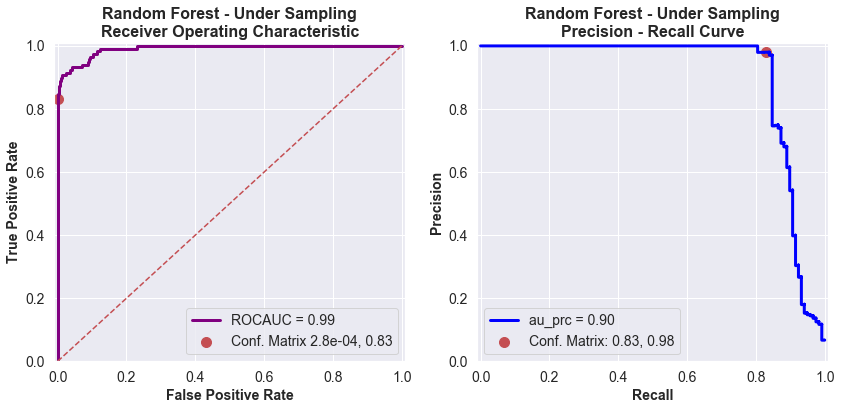

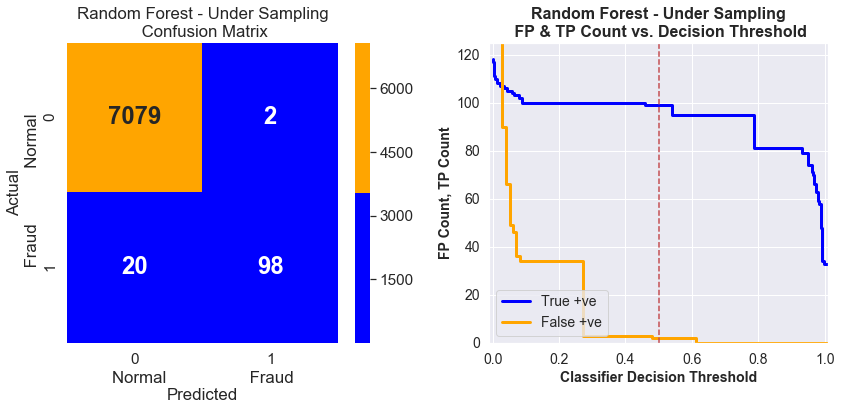

In [65]:
US_RFC_model = clf.best_estimator_
y_pred, probs, F1_Score = GetResults('Random Forest - Under Sampling', US_RFC_model, x_test_u, y_test_u, Pu, Nu, 0, 0.5)

##  Now apply the model to the original size test set and see the results before calibrating the probabilities and decision thresholds.

 

Random Forest - Undersampling gives AU_PRC of 0.818and F1 Score of 0.817



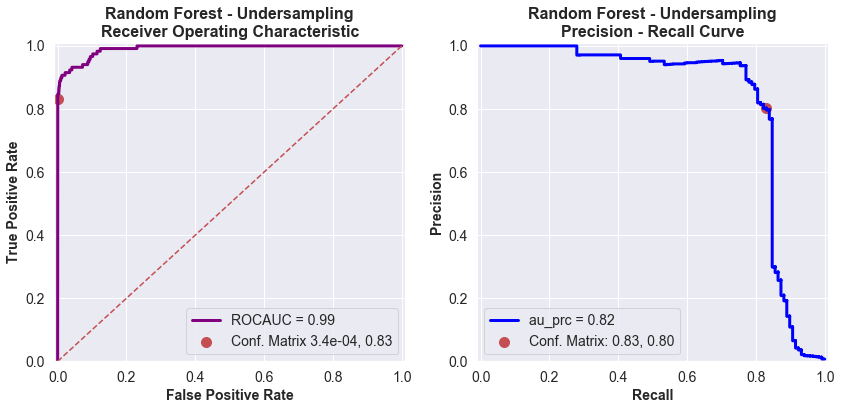

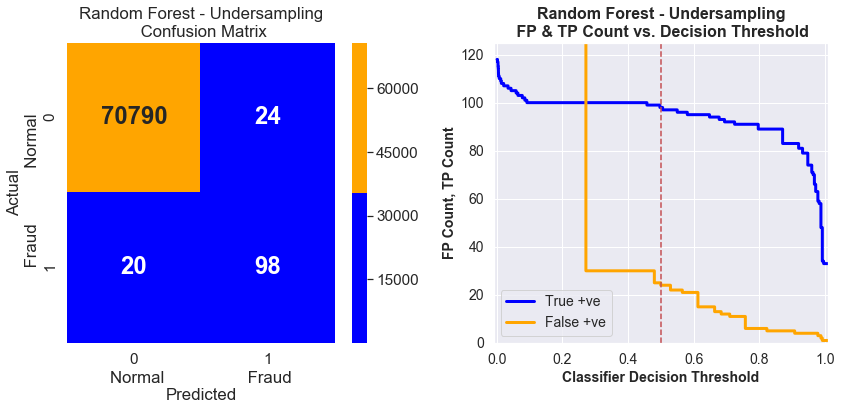

In [66]:
y_pred, probs, F1_Score = GetResults('Random Forest - Undersampling', US_RFC_model, x_test, y_test, P, N, 2, 0.5)

In [67]:
fpr_, tpr_, thresholds_ = roc_curve(y_test, probs[:,1])
FP_TP_Count_Table('Random Forest - Undersampling', fpr_, tpr_, thresholds_, Ps, Ns, 30)

    ROC Curve TP & FP Count by Classifier Decision Threshold:    
                  Random Forest - Undersampling                  

-----------------------------------------------------------------
    i   Threshold       TPR      TP Count      FPR       FP Count
-----------------------------------------------------------------
    0       2.000       0.000         0.0     0.0e+00         0.0
    1       1.000       0.280        33.0     1.4e-05         1.0
    2       0.993       0.288        34.0     1.4e-05         1.0
    3       0.992       0.407        48.0     2.8e-05         2.0
    4       0.984       0.492        58.0     4.2e-05         3.0
    5       0.981       0.500        59.0     4.2e-05         3.0
    6       0.976       0.534        63.0     5.6e-05         4.0
    7       0.968       0.559        66.0     5.6e-05         4.0
    8       0.968       0.593        70.0     5.6e-05         4.0
    9       0.960       0.602        71.0     5.6e-05         4.0
   10    

###### Now calibrate the probabilities and decision threshold  using eqn (9) as proposed by Dal Pozzolo et al: Calibrating Probability with Undersampling for Unbalanced Classification. In Symposium on Computational Intelligence and Data Mining (CIDM), IEEE, 2015
p' = Bps/ (Bps - ps +1), B = Ns-/N-, Here B = 28324/283253  The decision threshold before adjustment taken from the table above should be 0.78  (where the slope of false poitives is higher than true positives)

In [68]:
def Calib_Probs_Preds(Probs, Nu, N, DT):
    Beta = Nu/N
    #Calibrated Probabilities and adjusted decision threshold

    if DT != 0.5:
        ADT = (DT * Nu/N)/((DT * Nu/N) - DT + 1)
    else:
        ADT = 0.5

    Probs_calibrated = (Beta*Probs)/((Beta*Probs) - Probs + 1)

    Preds = np.empty((Probs.shape[0],1))
    Preds[:,0] = Probs_calibrated[:,1]>ADT

    return Probs_calibrated, Preds, ADT

In [69]:
#Calibrated predictions and probabilities
calib_probs, calib_preds, ADT = Calib_Probs_Preds(probs, Nu, N, 0.78)
calib_probs.shape, calib_preds.shape, ADT, probs.shape, N

((70932, 2), (70932, 1), 0.26173405123432286, (70932, 2), 70814)

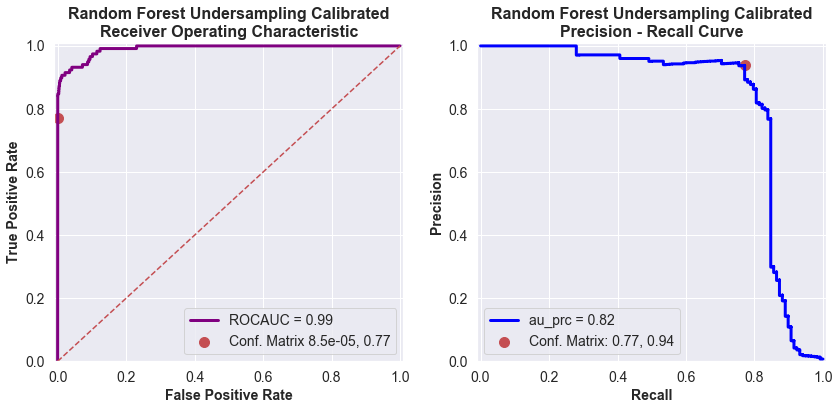

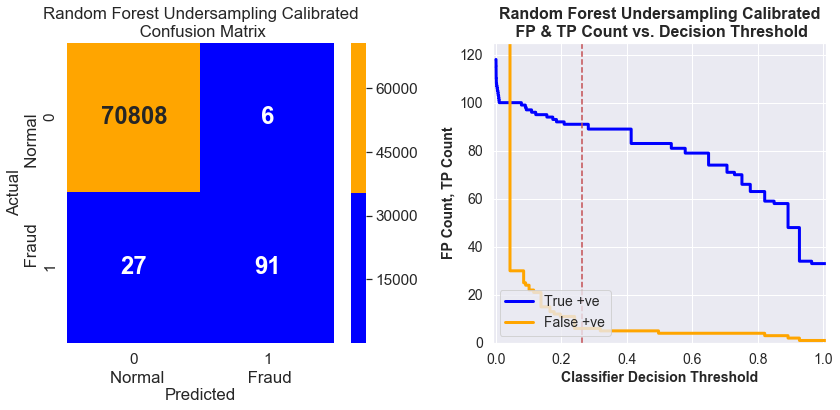

In [70]:
cm = confusion_matrix(y_test, calib_preds)
ROC_Pre_Count_Plots('Random Forest Undersampling Calibrated', y_test, calib_preds, calib_probs, cm, P, N, ADT)

In [71]:
print(('F1 Score is {:.3f}').format(f1_score(y_test,calib_preds)))

F1 Score is 0.847


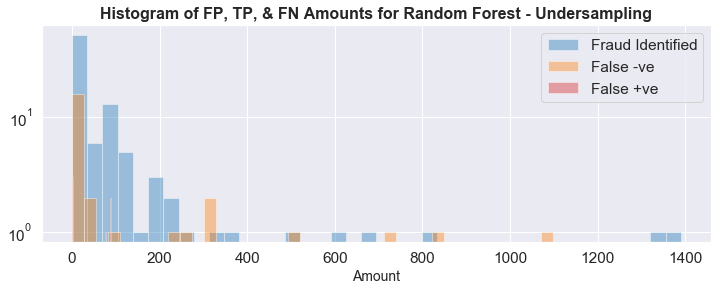

Fraud total identified is 9779.62,
Fraud total missed is 4547.27,
Normal total misclassified is 259.12


In [72]:
Det_Amt_PLot('Random Forest - Undersampling', Test_Set_10, y_test_10, calib_preds)

### *Observation: Compared to Random Forest fitted on the full training set (Part A), the adjusted undersampled result has a lower AU-PRC and a similar F1 Score (0.847 vs. 0.845). The results are similar to Random Forest on 10 features above.   This model identified almost the same value amount of frauds and false positives as the full traing RF model in part A.  It identified a higher amount of frauds (~ 110 more) then the RF model on 10 features, but also higher false positives (~ 255 more).  

### Another undersampling ratio may give better results.

## Optimize the MLP Classifier with the undersampled dataset.

In [73]:
params={'hidden_layer_sizes':[10, 30, 50, 70, 90, 110, 130, 150, 170], 'activation':['tanh','logistic','relu'],'solver':['lbfgs','sgd','adam']}

model =  MLPClassifier(batch_size = 1000, max_iter = 200,random_state = 6)
clf = RandomizedSearchCV(model, param_distributions=params, n_iter=30, cv=3, verbose=1, return_train_score=True, n_jobs = -1)

clf.fit(x_train_u, y_train_u)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  2.8min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                           batch_size=1000, beta_1=0.9,
                                           beta_2=0.999, early_stopping=False,
                                           epsilon=1e-08,
                                           hidden_layer_sizes=(100,),
                                           learning_rate='constant',
                                           learning_rate_init=0.001,
                                           max_iter=200, momentum=0.9,
                                           n_iter_no_change=10,
                                           nesterovs_momentum=True, power_t=0.5,
                                           random...
                                           solver='adam', tol=0.0001,
                                           validation_fraction=0.1,
                                          

In [74]:
clf.best_params_

{'solver': 'adam', 'hidden_layer_sizes': 90, 'activation': 'relu'}

model parameters:  {'activation': 'relu', 'alpha': 0.0001, 'batch_size': 1000, 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': 90, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_iter': 200, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': 6, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}

MLP - Undersampling gives AU_PRC of 0.916and F1 Score of 0.908



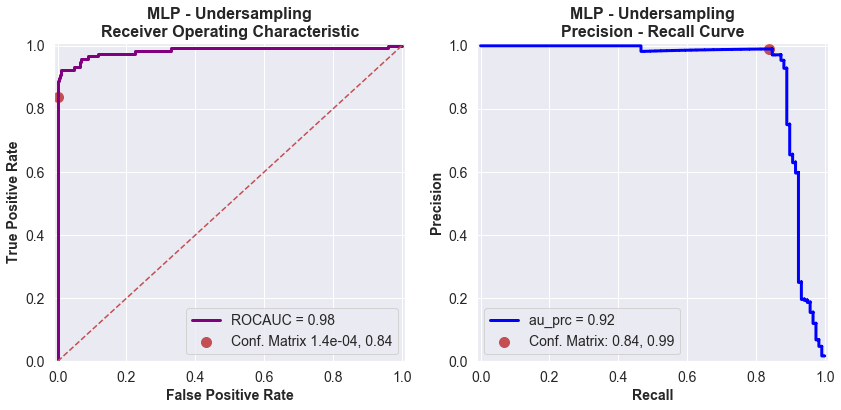

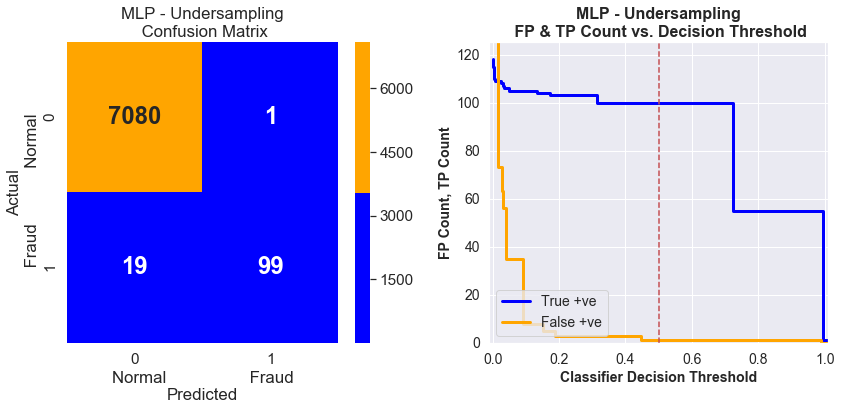

In [75]:
US_MLP_model = clf.best_estimator_
y_pred, probs, F1_Score = GetResults('MLP - Undersampling', US_MLP_model, x_test_u, y_test_u, Pu, Nu, 0, 0.5)

##  Now apply the model to the original size test set and see the results before calibrating the probabilities and decision thresholds.

 

MLP - Undersampling gives AU_PRC of 0.841and F1 Score of 0.818



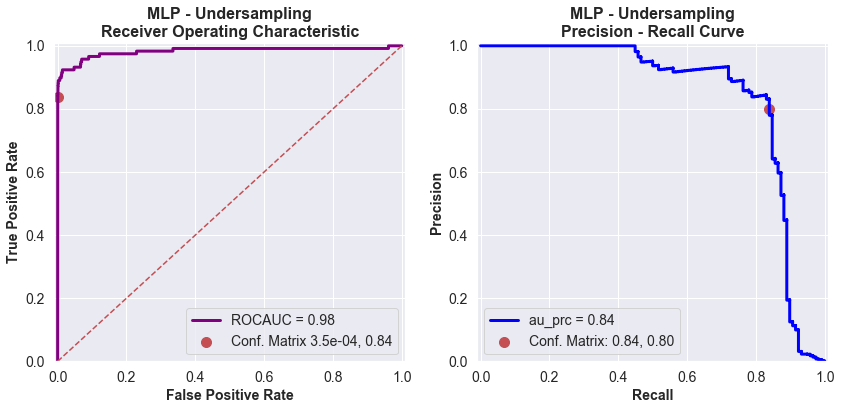

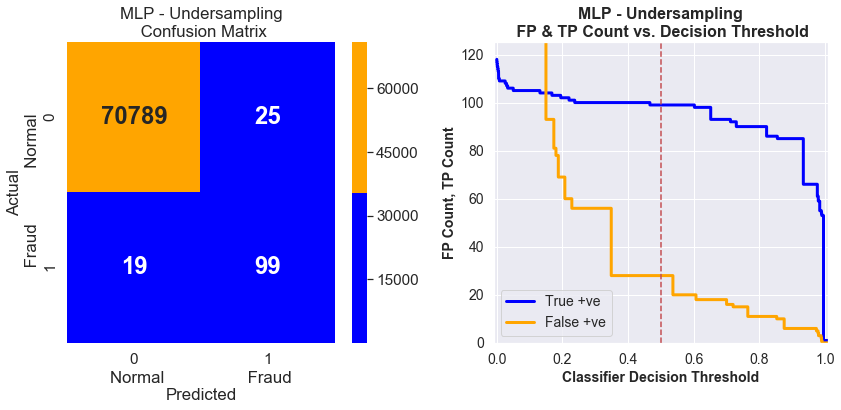

In [76]:
y_pred, probs, F1_Score = GetResults('MLP - Undersampling', US_MLP_model, x_test, y_test, P, N, 2, 0.5)

In [77]:
fpr_, tpr_, thresholds_ = roc_curve(y_test, probs[:,1])
FP_TP_Count_Table('MLP - Undersampling', fpr_, tpr_, thresholds_, Ps, Ns, 30)

    ROC Curve TP & FP Count by Classifier Decision Threshold:    
                       MLP - Undersampling                       

-----------------------------------------------------------------
    i   Threshold       TPR      TP Count      FPR       FP Count
-----------------------------------------------------------------
    0       2.000       0.000         0.0     0.0e+00         0.0
    1       1.000       0.008         1.0     0.0e+00         0.0
    2       0.992       0.449        53.0     0.0e+00         0.0
    3       0.991       0.449        53.0     1.4e-05         1.0
    4       0.990       0.458        54.0     1.4e-05         1.0
    5       0.990       0.458        54.0     2.8e-05         2.0
    6       0.989       0.466        55.0     2.8e-05         2.0
    7       0.988       0.466        55.0     4.2e-05         3.0
    8       0.981       0.500        59.0     4.2e-05         3.0
    9       0.981       0.500        59.0     5.6e-05         4.0
   10    

## Now calibrate the probabilities and decision threshold.

p' = Bps/ (Bps - ps +1), B = Ns-/N-, Here B = 28324/283253  The decision threshold before adjustment taken from the table above should be 0.79.

In [78]:
#Calibrated predictions and probabilities
calib_probs, calib_preds, ADT = Calib_Probs_Preds(probs, Nu, N, 0.79)
calib_probs.shape, calib_preds.shape, ADT, probs.shape, N

((70932, 2), (70932, 1), 0.27334518124420665, (70932, 2), 70814)

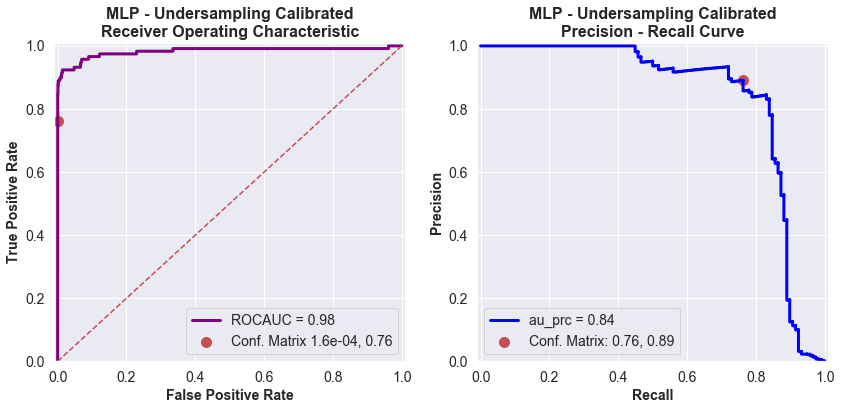

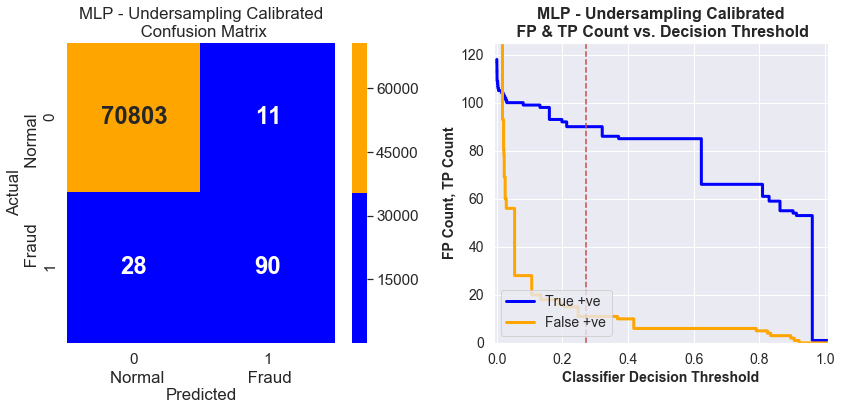

In [79]:
cm = confusion_matrix(y_test, calib_preds)
ROC_Pre_Count_Plots('MLP - Undersampling Calibrated', y_test, calib_preds, calib_probs, cm, P, N, ADT)

In [80]:
print(('F1 Score is {:.3f}').format(f1_score(y_test,calib_preds)))

F1 Score is 0.822


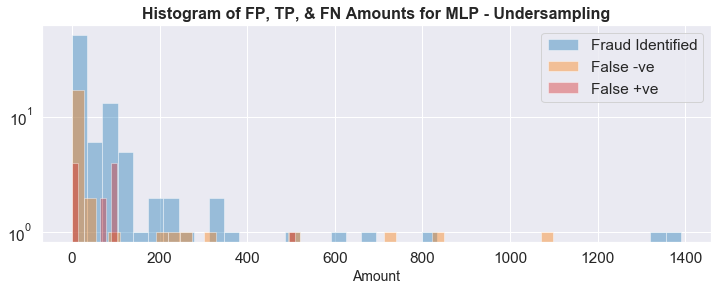

Fraud total identified is 9918.21,
Fraud total missed is 4408.68,
Normal total misclassified is 1023.89


In [81]:
Det_Amt_PLot('MLP - Undersampling', Test_Set_10, y_test_10, calib_preds)

### The calibrated results for Random Forest and MLP using Undersampling are similar.  The RF undersampled model has a slightly higher AUC but a lower F1 score.  The RF - US model has a fraud detection amount about 140 lower then the MLP-US model, but has a much lower false positive amount (259 vs 1023).  

## Autoencoders are continued in Part 3